# Emotion Classification using Anthropic Vision API

In [22]:
import os
import base64
import json
from pathlib import Path
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import anthropic
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Configuration
ANTHROPIC_API_KEY = "ANTHROPIC_API_KEY"
DATA_PATH = r"..\data\FER-2013\test"

# Emotion categories
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Initialize Anthropic client
client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [24]:
def encode_image_to_base64(image_path: str) -> str:
    """
    Encode an image file to base64 string.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        str: Base64 encoded image string
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def get_image_files_from_folder(folder_path: str, extensions: List[str] = ['.jpg', '.jpeg', '.png']) -> List[Tuple[str, str]]:
    """
    Get all image files from a folder with their true labels.
    
    Args:
        folder_path (str): Path to the main folder containing emotion subfolders
        extensions (List[str]): List of image file extensions to consider
        
    Returns:
        List[Tuple[str, str]]: List of (image_path, true_label) tuples
    """
    image_files = []
    
    for emotion in EMOTIONS:
        emotion_folder = os.path.join(folder_path, emotion)
        if os.path.exists(emotion_folder):
            for file_name in os.listdir(emotion_folder):
                if any(file_name.lower().endswith(ext) for ext in extensions):
                    image_path = os.path.join(emotion_folder, file_name)
                    image_files.append((image_path, emotion))
    
    return image_files

In [25]:
def classify_emotion_with_anthropic(image_path: str) -> str:
    """
    Classify emotion in an image using Anthropic's Claude vision model.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        str: Predicted emotion label
    """
    try:
        # Encode image to base64
        base64_image = encode_image_to_base64(image_path)
        
        # Create the prompt for emotion classification
        prompt = f"""
        Please analyze this facial expression image and classify the emotion into one of these 7 categories:
        - angry
        - disgust
        - fear
        - happy
        - neutral
        - sad
        - surprise
        
        Look carefully at the facial features, especially:
        - Eyes (shape, eyebrows position)
        - Mouth (shape, corners)
        - Overall facial muscle tension
        - Act as if they are from FER 2013
        
        Respond with ONLY the emotion category name in lowercase, nothing else. ONLY RESPOND WITH THE EMOTION NAME.
        """
        
        # Make API call to Anthropic
        message = client.messages.create(
            model="claude-opus-4-1-20250805",
            max_tokens=10,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": base64_image
                            }
                        },
                        {
                            "type": "text",
                            "text": prompt
                        }
                    ]
                }
            ]
        )
        
        # Extract and clean the response
        predicted_emotion = message.content[0].text.strip().lower()
        
        # Validate the response is one of our expected emotions
        if predicted_emotion not in EMOTIONS:
            print(f"Warning: Unexpected emotion prediction '{predicted_emotion}' for {image_path}")
            return "neutral"  # Default fallback
            
        return predicted_emotion
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return "neutral"  # Default fallback

In [26]:
def process_images_batch(image_files: List[Tuple[str, str]], max_images: int = None) -> pd.DataFrame:
    """
    Process a batch of images and return results as DataFrame.
    
    Args:
        image_files (List[Tuple[str, str]]): List of (image_path, true_label) tuples
        max_images (int, optional): Maximum number of images to process (for testing)
        
    Returns:
        pd.DataFrame: DataFrame with image paths, true labels, and predicted labels
    """
    results = []
    
    # Limit the number of images if specified
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"Processing {len(image_files)} images...")
    
    for i, (image_path, true_label) in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {os.path.basename(image_path)}")
        
        try:
            predicted_label = classify_emotion_with_anthropic(image_path)
            
            results.append({
                'image_path': image_path,
                'image_name': os.path.basename(image_path),
                'true_label': true_label,
                'predicted_label': predicted_label,
                'correct': true_label == predicted_label
            })
            
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            results.append({
                'image_path': image_path,
                'image_name': os.path.basename(image_path),
                'true_label': true_label,
                'predicted_label': 'error',
                'correct': False
            })
    
    return pd.DataFrame(results)

In [27]:
def calculate_accuracy_metrics(results_df: pd.DataFrame) -> Dict:
    """
    Calculate various accuracy metrics from the results.
    
    Args:
        results_df (pd.DataFrame): DataFrame with true and predicted labels
        
    Returns:
        Dict: Dictionary containing various metrics
    """
    # Filter out error cases
    valid_results = results_df[results_df['predicted_label'] != 'error']
    
    if len(valid_results) == 0:
        return {"error": "No valid predictions found"}
    
    true_labels = valid_results['true_label'].tolist()
    predicted_labels = valid_results['predicted_label'].tolist()
    
    # Overall accuracy
    overall_accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Per-class accuracy
    per_class_accuracy = {}
    for emotion in EMOTIONS:
        emotion_mask = valid_results['true_label'] == emotion
        if emotion_mask.sum() > 0:
            emotion_correct = valid_results[emotion_mask]['correct'].sum()
            emotion_total = emotion_mask.sum()
            per_class_accuracy[emotion] = emotion_correct / emotion_total
    
    # Classification report
    class_report = classification_report(true_labels, predicted_labels, 
                                       target_names=EMOTIONS, output_dict=True)
    
    return {
        'overall_accuracy': overall_accuracy,
        'per_class_accuracy': per_class_accuracy,
        'classification_report': class_report,
        'total_images': len(valid_results),
        'error_count': len(results_df) - len(valid_results)
    }

def plot_confusion_matrix(results_df: pd.DataFrame):
    """
    Plot confusion matrix for the classification results.
    
    Args:
        results_df (pd.DataFrame): DataFrame with true and predicted labels
    """
    # Filter out error cases
    valid_results = results_df[results_df['predicted_label'] != 'error']
    
    if len(valid_results) == 0:
        print("No valid predictions to plot")
        return
    
    true_labels = valid_results['true_label'].tolist()
    predicted_labels = valid_results['predicted_label'].tolist()
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=EMOTIONS)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=EMOTIONS, yticklabels=EMOTIONS)
    plt.title('Confusion Matrix - Emotion Classification')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def plot_accuracy_by_emotion(metrics: Dict):
    """
    Plot per-class accuracy as a bar chart.
    
    Args:
        metrics (Dict): Metrics dictionary from calculate_accuracy_metrics
    """
    if 'per_class_accuracy' not in metrics:
        print("No per-class accuracy data available")
        return
    
    emotions = list(metrics['per_class_accuracy'].keys())
    accuracies = list(metrics['per_class_accuracy'].values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(emotions, accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.title('Accuracy by Emotion Category')
    plt.xlabel('Emotion')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
# Main execution
if __name__ == "__main__":
    # Get all image files from the test directory
    print("Loading image files...")
    image_files = get_image_files_from_folder(DATA_PATH)
    print(f"Found {len(image_files)} images total")
    
    # Print distribution of images by emotion
    emotion_counts = {}
    for _, emotion in image_files:
        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
    
    print("\nDistribution of images by emotion:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count} images")
    
    TEST_IMAGES_PER_EMOTION = 5
    
    # Sample images for testing
    sampled_images = []
    for emotion in EMOTIONS:
        emotion_images = [img for img in image_files if img[1] == emotion]
        sampled_images.extend(emotion_images[:TEST_IMAGES_PER_EMOTION])
    
    print(f"\nProcessing {len(sampled_images)} sample images ({TEST_IMAGES_PER_EMOTION} per emotion)...")

Loading image files...
Found 7178 images total

Distribution of images by emotion:
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  neutral: 1233 images
  sad: 1247 images
  surprise: 831 images

Processing 35 sample images (5 per emotion)...


In [29]:
results_df = process_images_batch(sampled_images)

Processing 35 images...
Processing image 1/35: PrivateTest_10131363.jpg
Processing image 2/35: PrivateTest_10304478.jpg
Processing image 3/35: PrivateTest_1054527.jpg
Processing image 4/35: PrivateTest_10590091.jpg
Processing image 5/35: PrivateTest_1109992.jpg
Processing image 6/35: PrivateTest_11895083.jpg
Processing image 7/35: PrivateTest_19671520.jpg
Processing image 8/35: PrivateTest_21629266.jpg
Processing image 9/35: PrivateTest_22382996.jpg
Processing image 10/35: PrivateTest_26306320.jpg
Processing image 11/35: PrivateTest_10153550.jpg
Processing image 12/35: PrivateTest_10254684.jpg
Processing image 13/35: PrivateTest_10306709.jpg
Processing image 14/35: PrivateTest_10555537.jpg
Processing image 15/35: PrivateTest_10629254.jpg
Processing image 16/35: PrivateTest_10077120.jpg
Processing image 17/35: PrivateTest_10470092.jpg
Processing image 18/35: PrivateTest_10513598.jpg
Processing image 19/35: PrivateTest_10516065.jpg
Processing image 20/35: PrivateTest_10613684.jpg
Process

In [30]:
# Calculate accuracy metrics
print("Calculating accuracy metrics...")
metrics = calculate_accuracy_metrics(results_df)

# Print overall results
print(f"\n=== CLASSIFICATION RESULTS ===")
print(f"Total images processed: {metrics['total_images']}")
print(f"Images with errors: {metrics['error_count']}")
print(f"Overall accuracy: {metrics['overall_accuracy']:.3f}")

print(f"\nPer-class accuracy:")
for emotion, accuracy in metrics['per_class_accuracy'].items():
    print(f"  {emotion}: {accuracy:.3f}")

# Display detailed classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
report_df = pd.DataFrame(metrics['classification_report']).transpose()
print(report_df.round(3))

# Save results to CSV
results_df.to_csv('emotion_classification_results.csv', index=False)
print(f"\nResults saved to 'emotion_classification_results.csv'")

Calculating accuracy metrics...

=== CLASSIFICATION RESULTS ===
Total images processed: 35
Images with errors: 0
Overall accuracy: 0.371

Per-class accuracy:
  angry: 0.000
  disgust: 0.000
  fear: 0.200
  happy: 0.800
  neutral: 1.000
  sad: 0.000
  surprise: 0.600

=== DETAILED CLASSIFICATION REPORT ===
              precision  recall  f1-score  support
angry             0.000   0.000     0.000    5.000
disgust           0.000   0.000     0.000    5.000
fear              0.500   0.200     0.286    5.000
happy             0.333   0.800     0.471    5.000
neutral           0.385   1.000     0.556    5.000
sad               0.000   0.000     0.000    5.000
surprise          0.750   0.600     0.667    5.000
accuracy          0.371   0.371     0.371    0.371
macro avg         0.281   0.371     0.283   35.000
weighted avg      0.281   0.371     0.283   35.000

Results saved to 'emotion_classification_results.csv'


c:\Users\nmahesh\OneDrive - Eastside Preparatory School\Documents\code\asd-multimodal-emotion-fusion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nmahesh\OneDrive - Eastside Preparatory School\Documents\code\asd-multimodal-emotion-fusion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nmahesh\OneDrive - Eastside Preparatory School\Documents\code\asd-multimodal-emotion-fusion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning

Generating confusion matrix...


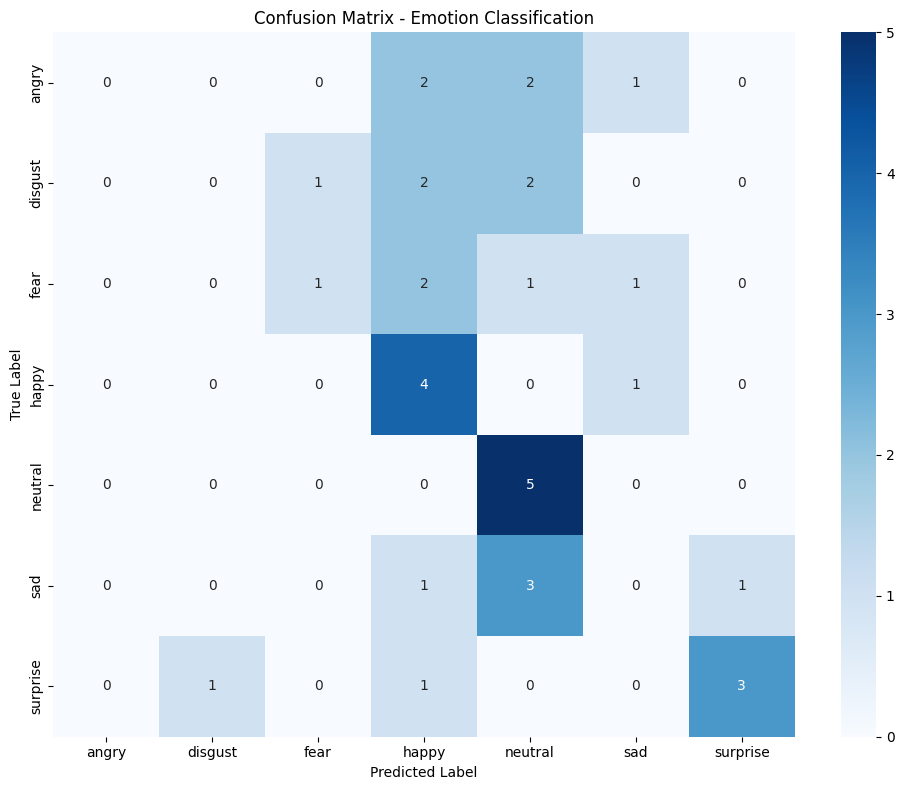

Generating accuracy by emotion chart...


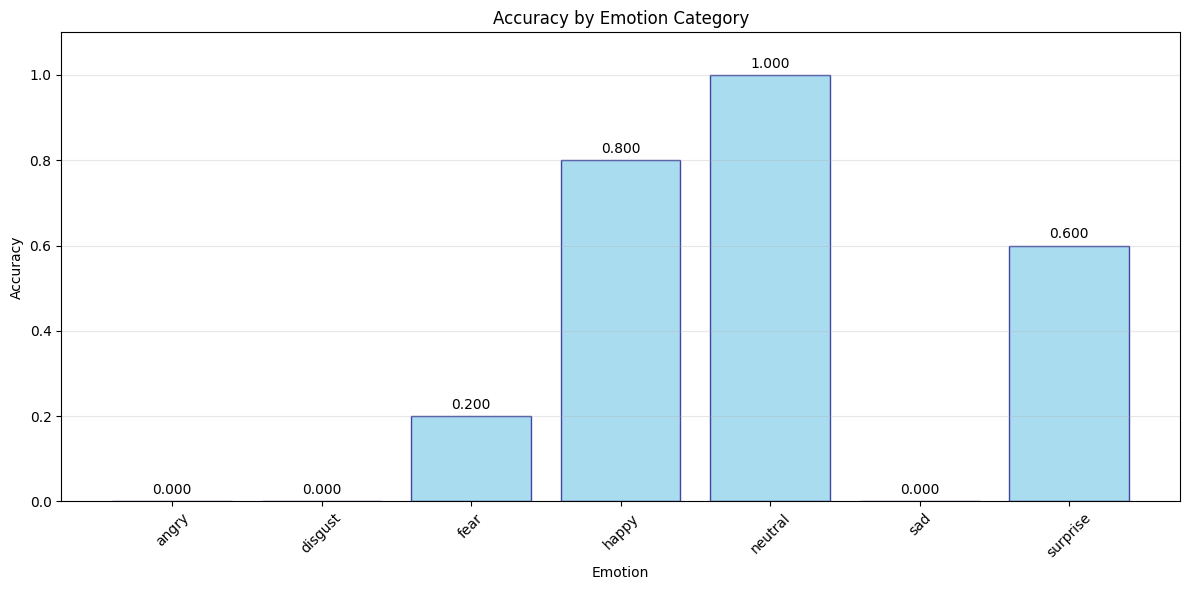

\n=== SAMPLE PREDICTIONS ===
Wrong: PrivateTest_10131363.jpg: angry → neutral
Wrong: PrivateTest_10304478.jpg: angry → happy
Wrong: PrivateTest_1054527.jpg: angry → sad
Wrong: PrivateTest_10590091.jpg: angry → neutral
Wrong: PrivateTest_1109992.jpg: angry → happy
Wrong: PrivateTest_11895083.jpg: disgust → fear
Wrong: PrivateTest_19671520.jpg: disgust → happy
Wrong: PrivateTest_21629266.jpg: disgust → neutral
Wrong: PrivateTest_22382996.jpg: disgust → neutral
Wrong: PrivateTest_26306320.jpg: disgust → happy


In [32]:
# Plot confusion matrix
print("Generating confusion matrix...")
plot_confusion_matrix(results_df)

# Plot accuracy by emotion
print("Generating accuracy by emotion chart...")
plot_accuracy_by_emotion(metrics)

# Show sample predictions
print("\\n=== SAMPLE PREDICTIONS ===")
sample_results = results_df.head(10)
for _, row in sample_results.iterrows():
    status = "Correct:" if row['correct'] else "Wrong:"
    print(f"{status} {row['image_name']}: {row['true_label']} → {row['predicted_label']}")